In [170]:
from astropy.io import fits
import numpy as np
import glob
from astropy import units as u
#Import astropy cutout2d
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

#Use astropy to load in the fits files 'coadd.fits' and 'coadd600.fits'
hdulist = fits.open('coadd.fits') 
hdulist600 = fits.open('coadd600.fits')

#Show the headers of the fits files
print(hdulist[0].header)









SIMPLE  =                    T / This is a FITS file                            BITPIX  =                  -32 /                                                NAXIS   =                    2 /                                                NAXIS1  =                 2971 / Number of pixels along this axis               NAXIS2  =                 3096 / Number of pixels along this axis               EXTEND  =                    T / This file may contain FITS extensions          EQUINOX =   2.000000000000E+03 / Mean equinox                                   MJD-OBS =   5.966017589700E+04 / Modified Julian date at start                  RADESYS = 'ICRS    '           / Astrometric system                             CTYPE1  = 'RA---TAN'           / WCS projection type for this axis              CUNIT1  = 'deg     '           / Axis unit                                      CRVAL1  =   1.865218417250E+02 / World coordinate on this axis                  CRPIX1  =   9.960000000000E+02 / Referen

(2928, 2893)

In [147]:
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm


def cutout(hdu, position, size, outputname):
    wcs = WCS(hdu[0].header)
    cutout = Cutout2D(hdu[0].data, position ,size, wcs = wcs )

    #Show the image with logarithmic scale
    plt.imshow(cutout.data, origin='lower', cmap='gray', norm=LogNorm(vmin=0.001, vmax=np.max(cutout.data)))
    plt.colorbar()
    plt.show()

    plt.imshow(data, origin='lower', norm=LogNorm(vmin=2, vmax=np.max(cutout.data)))
    cutout.plot_on_original(color='lime', linewidth=3)
    plt.show()
    
    #Save cutout.data to a new fits file
    img_hdu = fits.PrimaryHDU(cutout.data, header=hdulist[0].header)
    img_hdu.writeto(outputname + '.fits', overwrite=True) 

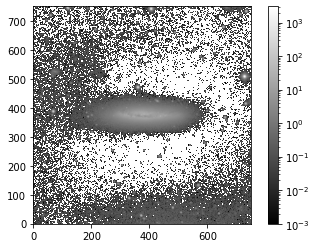

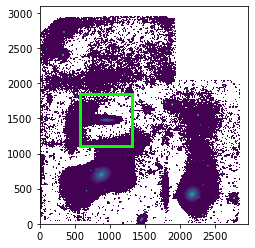

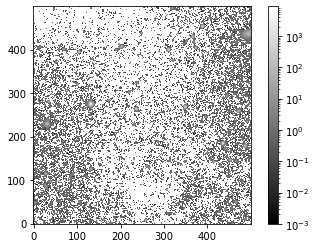

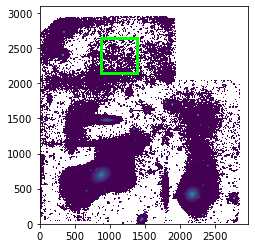

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'skybg_R4.fits'

In [173]:
data = hdulist[0].data
#Position of NGC4402 is 12h26m07.0s, +13d06m45.0s (ICRS)
position = SkyCoord('12h26m08.0s', '+13d06m45.0s', frame='fk5')
size = (750*u.pixel, 750*u.pixel)


cutout(hdulist, position, size, 'NGC4402_hawide')
plt.show()

position2 = SkyCoord('12h25m54.5s', '+13d19m23.0s', frame='fk5')
size2 = (500*u.pixel, 500*u.pixel)

cutout(hdulist600, position2, size2, 'skybg_R4')

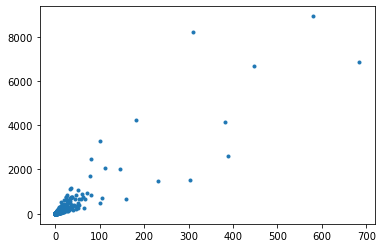

[12.42200799]


ValueError: operands could not be broadcast together with shapes (3096,2971) (2928,2893) 

In [168]:
#Now lets work with the sky background to do a continuum subtraction to get the h alpha emission line

#Use astropy to load in the fits files 'coadd.fits' and 'coadd600.fits'
ha = fits.open('skybg_ha4.fits') 
R = fits.open('skybg_R4.fits')

hdata = ha[0].data
Rdata = R[0].data

#Turn all values under 5 in hdata and Rdata into nan
#hdata[hdata<5] = np.nan
#Rdata[Rdata<5] = np.nan

hflat = hdata.flatten()

#Plot the hdata and Rdata arrays against eachother to see if they are the same
plt.plot(hdata.flatten(), Rdata.flatten(), '.')
#plt.xlim(0,500)
plt.show()

def line(x,a):
    return a*x

#Fit a line to the data and return the slope. intercept = 0
from scipy.optimize import curve_fit
popt, pcov = curve_fit(line, hdata.flatten(), Rdata.flatten())
print(popt)





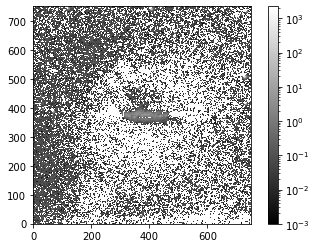

In [176]:
ha4402 = fits.open('NGC4402_hawide.fits') 
R4402 = fits.open('NGC4402_Rwide.fits')
hadata = ha4402[0].data
Rdata = R4402[0].data
continuumsub = hadata - Rdata/popt[0]
#Show the image with logarithmic scale
plt.imshow(continuumsub, origin='lower', cmap='gray', norm=LogNorm(vmin=0.001, vmax=np.max(continuumsub)))
plt.colorbar()
plt.show()

img_hdu = fits.PrimaryHDU(continuumsub, header=hdulist[0].header)
img_hdu.writeto('continuumsub.fits', overwrite=True) 